<a href="https://colab.research.google.com/github/tedteske/tourneystruct/blob/master/tourneystruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
from scipy.stats import spearmanr
import scipy.stats 
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8,5)})
plt.rcParams["font.family"] = "serif"

class tstruct:
    '''
    Class of tournament structure (tstruct) object.

    Attributes
    ----------
    players : DataFrame; columns are names of competitors; rows are players'
              population average and standard deviation scores. These represent,
              respecively, talent and consistency.
    asc     : boolean;  if True, scores are sorted ascending
                        if False, scores are sorted descending
                        for the purposes of seeding and determining winners
    
    Methods
    -------
    new_scores() : Creates an array of normal variates and writes to a Series.
    generate_seed_order() : Generates a standard seeding order.
    custom_seed_order() : Parses user-defined seeding order.
    seed_scores() : Applies seeding order to scores.
    race() : Outputs tounament stage winners and losers by heat.
    tourney() : Runs tournament and outputs rankings, various stats, 
                and bracket.
    calc_tourney_corrs() :  Runs multiple simulations of several tournament 
                structures. Outputs dictionaries of simulated tournament 
                rankings' correlations with rankings of players' average scores.
    plot_corrs_distribution() : Plots the frequency distribution of tournament 
                rank correlations.
    plot_player_specs() : Scatter plots mean tournament rank correlations 
                vs the spreads of mu and sigma.
    '''
    
    def __init__(self, nplayers, mu=0, sigma=1, asc=True):
        a = np.empty((2, nplayers), dtype=float)
        a[0], a[1] = mu, sigma
        self.players = pd.DataFrame(a)
        self.players.rename({0:'mu', 1:'sigma'}, axis='index', inplace=True)
        self.players.columns = self.players.columns + 1
        self.asc = asc
        return None
        
    def __call__(self):
        self.new_scores()
        return self.tourney()

    def new_scores(self, nstages=None, heat_size=2, nsims=1):
        '''
        Samples scores from each player's underlying talent ('mu') and 
        consistency ('sigma') as an array of normal variates and writes to 
        Series self.scores. The number of samples is determined by the 
        maximum number of scores needed to play a single-elimination tournament
        of any format times the number of simulations of that tournament:

            number of sample scores = simulatios x stages x players

        Parameters
        ----------
        nsims : integer > 0; default 1; number of simulations
        nstages : None or integer >= 0; default None; number of stages     
        heat_size : integer > 0; default 2; size of each heat
        '''
        
        try:
            self.players.rename({0:'mu', 1:'sigma'}, axis='index', inplace=True)
        except:
            pass
        
        mu = self.players.loc['mu']
        sigma = self.players.loc['sigma']    
        nplayers = len(self.players.columns)
        
        if nstages is None or nstages == 0:
            '''
            Example: If there are 16 players in a standard tennis-style 
            tournament, then the number of stages or rounds is log_2(16) = 4.
            Another way to think about it: how many doublings does it take
            to get from 1 to 16? 4
            '''
            nstages = math.ceil(math.log(nplayers, heat_size))
        
        scores = np.random.normal(mu, sigma, size=(nsims, nstages, nplayers))
        
        # Create MultiIndex of sims, stages, players. 
        index_level_names = ['sim', 'stage', 'player']
        index_levels = [range(s) for s in scores.shape]
        index = pd.MultiIndex.from_product(index_levels, 
                                           names=index_level_names)
        
        # Convert scores to DataFrame, apply MultiIndex, and flatten to Series.
        scores = pd.DataFrame({'scores' : scores.flatten()},
                              index=index)['scores']
        scores.index.set_levels(self.players.columns, level=2, inplace=True)
        self.scores = scores
        
        return None   

    def generate_seed_order(self, nplayers, heat_size):
        '''
        Generates a standard seeding order: Creates an array of integers 
        representing the arrangment of seeds in the first stage, or round, to 
        maximize the likelihood that the best players advance. 
        
        For example, in the first round of a tennis-style tournament, the first 
        seed should play the last seed, the second seed should play the next 
        last seed, and the top two seeds should meet no earlier than the finals.

        Parameters
        ----------
        nplayers : integer > 0; number of players     
        heat_size : integer > 0; default 2; size of each heat

        Returns
        -------
        array of integers; seed order
        '''
        
        seeds = np.asarray([0], dtype=int)

        while len(seeds) < nplayers:
            nseeds = len(seeds)
            new_seeds = np.empty(nseeds * heat_size, dtype=int)
            new_seeds[0::heat_size] = seeds
            for i in range(1, heat_size):
                new_seeds[i::heat_size] = (nseeds * (i + 1)) - seeds - 1
            seeds = new_seeds
        
        return seeds

    def custom_seed_order(self, seeds):
        '''
        Parses user-defined seeding order.

        Parameters
        ----------
        seeds : list or array of integers; user defined seed order with the 
                special values
                -1 for randmonly-assigned non-seeds, and
                -2 for byes   

        Returns
        -------
        seeds : array of integers; seed order  
        '''
        
        np.random.seed()
        seeds = np.asarray(seeds).flatten()
        
        for i in [-1, -2]:
            not_seeded = np.count_nonzero(seeds == i)
            next_seed = seeds.max() + 1
            new_seeds = np.arange(next_seed, next_seed + not_seeded)
            if i == -1:
                np.random.shuffle(new_seeds)
            np.place(seeds, seeds==i, new_seeds)
        
        seeds = list(seeds - 1)  
        return seeds

    def seed_scores(self, scores, heat_size, seed=True, seed_sort_on='mu', 
                    bye_score=100):
        '''
        Applies seed order from generate_seed_order() or 
        custom_seed_order() to players based on field (default mu) in scores.

        Parameters
        ----------
        scores : Series; players' sample scores    
        heat_size : integer > 0; size of each heat
        seed :  boolean; default True; 
                    if True: seed tournament using standard seed order
                    if False: do not seed tournament
                list or array of integers; user defined seed order
        seed_sort_on : string; default "mu"; field on which players are seeded
        bye_score : integer; default 100; score attributed to byes so that they
                    always sort last
        
        Returns
        -------
        scores : Series; scores table, in seed order
        seeds : array of integers; seed order  
        '''
                
        nplayers = len(scores.columns)
        players = self.players[scores.columns]
        
        if seed is True:
            seeds = self.generate_seed_order(nplayers, heat_size)
        else:
            seeds = self.custom_seed_order(seed)
        
        players_sort = players.loc[seed_sort_on].sort_values(ascending=self.asc)
        scores = scores.reindex(players_sort.index, axis=1)
        
        nbyes = len(seeds) - nplayers
        for i in range(nbyes): 
            bye_col = "B" + str(i)
            scores[bye_col] = bye_score

        scores = scores.iloc[:,seeds]
        return scores, seeds

    def race(self, scores, stage, heat_size=2, top=1):
        '''
        Outputs tounament stage winners and losers by heat.

        Parameters
        ----------
        scores : DataFrame; scores table
        stage : integer; tournament round (e.g. 0 for first round, 1 for second)
        heat_size : integer > 0; default 2; size of each heat
        top : integer; number of players who advance to next round
        
        Returns
        -------
        winners : list
        losers : list
        '''
        
        nplayers = len(scores.columns)
        heat_size = min(heat_size, nplayers)
        heats = math.ceil(nplayers / heat_size) # divides then rounds up
             
        winners, losers_unsorted = [], []
        for heat in range(heats):
            start_col = heat * heat_size
            end_col = start_col + heat_size
            results_unsorted = scores.iloc[stage, start_col:end_col]
            results = results_unsorted.sort_values(ascending=self.asc).index
            winners += list(results[0:top])
            losers_unsorted += list(results[top:])
        losers_unsorted = scores[losers_unsorted].iloc[stage,:]
        losers = list(losers_unsorted.sort_values(ascending=self.asc).index)
        
        return winners, losers
   
    def tourney(self, sim=0, heat_size=2, top=1, top_fraction=1, 
                seed=False, reseed=False, seed_sort_on='mu',
                show_stats=False, show_brackets=False):
        '''
        Runs tournament and outputs rankings, various stats, and bracket.

        Parameters
        ----------
        sim :  integer; simulation number   
        heat_size : integer > 0; default 2; size of each heat
        top : integer; number of players who advance to next round
        top_fraction : fraction of players who advance to next round
        seed :  boolean; default False; 
                    if True: seed tournament using standard seed order
                    if False: do not seed tournament
                list or array of integers; user defined seed order
        reseed : boolean; default False; if True, reseed at each round
        seed_sort_on : string; default "mu"; field on which players are seeded
        show_stats : boolean; default False; if True, return tourney stats
        show_brackets : boolean; default False; if True, return tourney bracket
        
        Returns
        -------
        ranked : Series
        '''
        
        nplayers = len(self.players.columns)
        scores_ = self.scores[sim].unstack()
        
        if seed: 
            scores_, seeds = self.seed_scores(scores_, heat_size, 
                                              seed, seed_sort_on)

        remaining_players = list(scores_.columns) # inlcudes byes, if any
        nscores_used = nplayers - len(remaining_players) - 1 # negative byes
        
        brackets = []
        all_losers = []
        stage, last_count, next_count = 0, 1, 0

        while last_count > next_count:
            
            nscores_used += last_count
            last_count = len(remaining_players)
            
            top = min(top, 
                      math.ceil(top_fraction * min(heat_size, last_count)))

            if show_brackets:
                bracket = [remaining_players[i:i + heat_size] 
                           for i in range(0, last_count, heat_size)]
                brackets.append(bracket)
         
            if last_count > top:
                try:
                    scores_ = scores_[remaining_players]
                    remaining_players, losers = self.race(scores_, stage, 
                                                          heat_size, top)
                    #all_losers += losers
                    all_losers = losers + all_losers
                    stage += 1
                    next_count = len(remaining_players)

                    if reseed and seed and next_count > heat_size:
                        scores_ = scores_[remaining_players]
                        scores_ = self.seed_scores(scores_, heat_size)[0]
                        remaining_players = list(scores_.columns)
                        
                except IndexError:
                    print("Error: Not enough scores to complete this tourney. "\
                          "Try increasing nstages when calling new_scores().\n")
                
        # Why not use pandas.DataFrame.rank?
        ranked = remaining_players + all_losers
        ranked = ranked[:nplayers]
        ranked = pd.Series(ranked, name='Final Rank')
        ranked.index = ranked.index + 1 #so first ranked player is 1
        
        if show_stats or show_brackets:
            stats = []
            if show_stats:
                nscores = stage * nplayers
                ranked_means = self.scores[sim].unstack().mean().sort_values()
                ranked_locs = self.players.iloc[0].sort_values()
                stats = {'nscores_used':nscores_used,
                         'nscores':nscores,
                         'efficiency':nscores_used/nscores,
                         'rho_avg': spearmanr(list(ranked),
                                              list(ranked_means.index))[0],
                         'rho_mu': spearmanr(list(ranked),
                                             list(ranked_locs.index))[0]}
            return pd.concat((ranked, pd.Series(stats), pd.Series(brackets)), 
                             keys = ('Final Rank', 'Statistics', 'Brackets'))
        else:
            return ranked

    def calc_tourney_corrs(self, tourney_args, nsims):
        '''
        Runs multiple simulations of several tournament structures. Outputs 
        dictionaries of simulated tournament rankings' correlations with 
        rankings of players' average scores.

        Parameters
        ----------
        tourney_args : dict; dictionary of parameters to pass to tourney()
        nsims : integer; number of simulations to run
        
        Returns
        -------
        results : dict; dictionary of correlations 
                    with keys same as for tourney_args
        means : dict; dictionary of mean correlations 
                    with keys same as for tourney_args
        '''
        
        self.new_scores(nsims=nsims)
        
        results = {key: [] for key in tourney_args} 
        means = {key: [] for key in tourney_args} 
        for j in tourney_args:    
            for sim in range(nsims):
                rho = self.tourney(sim=sim, 
                                   heat_size=tourney_args[j][0], 
                                   top=tourney_args[j][1], 
                                   top_fraction=tourney_args[j][2], 
                                   seed=tourney_args[j][3], 
                                   reseed=tourney_args[j][4],
                                   show_stats=True)['Statistics']['rho_avg']
                results[j].append(rho)           
            means[j].append(np.mean(results[j]))
        return results, means

    def plot_corrs_distribution(self, tourney_args, nsims):
        '''
        Plots the frequency distribution of tournament rank correlations.

        Parameters
        ----------
        tourney_args : dict; dictionary of parameters to pass to tourney()
        nsims : integer; number of simulations to run
        '''
        
        kde = True   
        results, means = self.calc_tourney_corrs(tourney_args, nsims)
        
        plots = 1
        fig, axes = plt.subplots(plots, 1, 
                             figsize=(10, plots * 10/1.6), 
                             sharex=True)
        
        for key in tourney_args:
            ax = sns.distplot(results[key], kde=kde, hist=not kde, label=key,
                            norm_hist=True, kde_kws={"bw":0.05, 'shade':True})   
            ax.set(xlabel='Spearman\'s rank correlation coefficient', 
                   ylabel='relative frequency')
            
            legend_title = None
            if kde:
                c = ax.get_lines()[-1].get_c()    
                plt.axvline(means[key], color=c, linestyle='--')
                legend_title = "------  means"        
                
        leg = plt.legend(title=legend_title, title_fontsize='medium')
        leg._legend_box.align = "left"
        plt.show()

    def plot_player_specs(self, tourney_args, nsims, spreads, 
                           mu_range, sigma_range):
        '''
        Scatterplots mean tournament rank correlations vs the spreads of mu
        and sigma.

        Parameters
        ----------
        tourney_args : dict; dictionary of parameters to pass to tourney()
        nsims : integer; number of simulations to run
        spreads : integer > 0; number of samples to generate 
        mu_range : list of size 2; min and max player mu
        sigma_range : list of size 2; min and max player sigma
        '''
        
        def corr_func(x,y, ax=None, **kws):
            '''
            Plot the correlation coefficient in the top left corner. Adapted
            from https://https://stackoverflow.com/questions/30942577
            '''
            rho = np.corrcoef(x,y)[1,0]
            label = r'$\rho$ = ' + str(round(rho, 2))
            ax = ax or plt.gca()
            ax.annotate(label, xy=(.05, .95), fontsize = 'medium', 
                        xycoords=ax.transAxes)

        nplayers = len(self.players.columns)
        
        sample_array = np.random.random_sample((2, nplayers, spreads))
        
        mus_ = np.linspace(mu_range[0], mu_range[1], spreads)
        mus = (mus_ * sample_array[0]).T
        
        sigmas_ = np.linspace(sigma_range[0], sigma_range[1], spreads)
        np.random.shuffle(sigmas_) # shuffles in place
        sigmas = (sigmas_ * sample_array[1]).T

        t_corrs = []
        for key in tourney_args:
            means = []
            for i in range(spreads):
                self.players.loc['mu'] = mus[i]
                self.players.loc['sigma'] = sigmas[i]
                results, means_ = self.calc_tourney_corrs(tourney_args, nsims)
                means.append(means_[key])
            
            means = list(np.asarray(means).flatten())
            
            dict1 = {'talent':mus_,
                     'consistency':sigmas_,
                     'mean correlations':means}
            df = pd.DataFrame(dict1)
            df['tourney'] = key
            t_corrs.append(df)
        
        t_corrs = pd.concat(t_corrs)
        t_corrs = t_corrs.melt(id_vars=['tourney', 'mean correlations'], 
                               var_name="spreads",
                               value_name="value")

        g = sns.FacetGrid(t_corrs, row="tourney", col='spreads', 
                          margin_titles=False, height=4, aspect=1.6,)
        g.map(sns.regplot,'value','mean correlations', 
              color=".3", fit_reg=True)
        g.map(corr_func,'value','mean correlations')

        plt.show()

### Example Usage and How-to

#### First example: Roger, Rafa, Novak, and Andy

Create a new tournament structure with 4 generic players, simulate the tournament, and print the results.

In [10]:
number_players = 4
new_tourn = tstruct(number_players, mu=0, sigma=1)
new_tourn.new_scores()
new_tourn.tourney(show_stats=True, show_brackets=True, seed=False)

Final Rank  1                              1
            2                              3
            3                              2
            4                              4
Statistics  nscores_used                   6
            nscores                        8
            efficiency                  0.75
            rho_avg                     -0.6
            rho_mu                       0.8
Brackets    0               [[1, 2], [3, 4]]
            1                       [[1, 3]]
            2                          [[1]]
dtype: object

These are the results of a 4-player, single elimination, 1 vs 1 tennis-style tournament. There are no seeds.

The function `new_scores()` generates an array of size $players \times stages$ and populated with normal variates. In this case, there are 4 players and 2 stages (semis and finals), therefore total 8 scores. Here are the scores generated by `new_scores()` and used to simulate this tournament.

In [11]:
new_tourn.scores

sim  stage  player
0    0      1        -0.233087
            2         0.755819
            3        -1.441880
            4         2.130076
     1      1         0.394035
            2         1.296122
            3         1.195358
            4        -1.314259
Name: scores, dtype: float64

The winner of each matchup is the lower of the two scores by default. The Final Rank is in the following order:
1. finals winner
2. finals loser
3. best semifinals loser (i.e. lowest score among semifinal losers)
4. next best semifinals loser  
...and so on for larger tournaments.

If `show_stats=True`, you see the following statistics: `scores_used`,   `nscores`, `efficiency`, `rho_avg`, `rho_mu`.

* `nscores` is the number of scores generated by `new_scores()`.
* `scores_used` is the number of those scores actually used to conduct the tournament.
* `efficiency` = `scores_used` / `nscores`, or the proportion of `nscores` used to conduct the tournament.
* `rho_avg` is the Spearman's rank correlation coefficient between Final Rank and sorted mean scores by player. This measures how well the tournament maps sample scores to Final Rank.
* `rho_mu` is the Spearman's rank correlation coefficient between Final Rank and sorted mean scores by player. This measures how well the tournament maps players' underlying talents to Final Rank.

Let's give the players more memorable names.

In [12]:
new_tourn.players.columns = ['Roger','Rafa','Novak','Andy']
new_tourn.new_scores()
new_tourn.tourney(show_stats=True, show_brackets=True, seed=False)

Final Rank  1                                        Roger
            2                                        Novak
            3                                         Andy
            4                                         Rafa
Statistics  nscores_used                                 6
            nscores                                      8
            efficiency                                0.75
            rho_avg                                    0.4
            rho_mu                                     0.4
Brackets    0               [[Roger, Rafa], [Novak, Andy]]
            1                             [[Roger, Novak]]
            2                                    [[Roger]]
dtype: object

This is what the `players` table looks like.

In [13]:
new_tourn.players

,Roger,Rafa,Novak,Andy
mu,0.0,0.0,0.0,0.0
sigma,1.0,1.0,1.0,1.0


Here, `mu` is the population mean score used by `new_scores()` to generate sample scores, and `sigma` is the population standard deviation. We can take `mu` to signify the the player's underlying talent, and `sigma` her or his consistency of play. 
In the above table, all players have the same talent and consistency. Let's add some variety:

In [14]:
new_tourn.players.loc['mu']=[0,1,2,3]
new_tourn.players.loc['sigma']=[1,2,2,3]
new_tourn.players

,Roger,Rafa,Novak,Andy
mu,0.0,1.0,2.0,3.0
sigma,1.0,2.0,2.0,3.0


Run the tournament again, using `mu` to seed the tournament bracket by setting `seed=True`.

In [15]:
new_tourn.new_scores()
results = new_tourn.tourney(show_stats=True, show_brackets=True, seed=True)
results

Final Rank  1                                        Roger
            2                                        Novak
            3                                         Rafa
            4                                         Andy
Statistics  nscores_used                                 6
            nscores                                      8
            efficiency                                0.75
            rho_avg                                      1
            rho_mu                                     0.8
Brackets    0               [[Roger, Andy], [Rafa, Novak]]
            1                             [[Roger, Novak]]
            2                                    [[Roger]]
dtype: object

And what is the probability of that final's outcome?

In [16]:
finals_stage = results.Brackets.index.max()
winner = results.Brackets[finals_stage][0][0]
loser = list(set(results.Brackets[finals_stage-1][0]) 
                - set(results.Brackets[finals_stage][0]))[0]

mu_A = new_tourn.players[winner][0]
mu_B = new_tourn.players[loser][0]
sigma_A = new_tourn.players[winner][1]
sigma_B = new_tourn.players[loser][1]
sigma_AB = np.sqrt(sigma_A**2 + sigma_B**2)

scipy.stats.norm(mu_B - mu_A, sigma_AB).sf(0)

0.8144533152386513

#### Heat Sizes

Create a new tournament structure with 9 generic players and heats of size 3, simulate the tournament, and print the results.

In [17]:
a = tstruct(9)
a.new_scores()
a.tourney(heat_size=3, show_stats=True, show_brackets=True)

Final Rank  1                                               7
            2                                               4
            3                                               2
            4                                               9
            5                                               5
            6                                               1
            7                                               6
            8                                               3
            9                                               8
Statistics  nscores_used                                   12
            nscores                                        18
            efficiency                               0.666667
            rho_avg                                 -0.133333
            rho_mu                                  0.0166667
Brackets    0               [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
            1                                     [[2, 4, 7]]
        

Create a Pinewood Derby structure with uneven den sizes and den champs advancing to finals. Simulate the tournament, and print the results.

In [18]:
B = -2 #bye value
seeds = [[1,2,3,B],
         [4,5,6,7],
         [8,9,B,B],
         [10,11,12,13]]

scouts = ['lion1','lion2','lion3',
          'tiger1','tiger2','tiger3','tiger4',
          'wolf1','wolf2',
          'bear1','bear2','bear3','bear4']

heat_size = 4 #size of largest den
derby = tstruct(13)

derby.players.columns = scouts 
derby.players.loc['seed_order']=list(range(13))

derby.new_scores(nstages=2, heat_size=heat_size) 
derby_results = derby.tourney(heat_size=heat_size, 
                              seed=seeds, seed_sort_on='seed_order',
                              show_stats=True, show_brackets=True)   
derby_results 

Final Rank  1                                                           bear4
            2                                                           lion3
            3                                                           wolf2
            4                                                          tiger4
            5                                                           lion2
            6                                                          tiger3
            7                                                          tiger1
            8                                                          tiger2
            9                                                           lion1
            10                                                          wolf1
            11                                                          bear1
            12                                                          bear3
            13                                                  

Create a structure similar like the Olympics' 100-meter sprints: heats of size 8 with top 3 from each heat advancing.

In [19]:
# https://en.wikipedia.org/wiki/100_metres_at_the_Olympics#Competition_format
sprint = tstruct(16)
heat_size = 8
sprint.new_scores(nstages=4, heat_size=heat_size)
sprint.tourney(heat_size=heat_size, top=3, top_fraction= 1, 
               show_stats=True, show_brackets=True)

Final Rank  1                                                              11
            2                                                              12
            3                                                               7
            4                                                               4
            5                                                               9
            6                                                               6
            7                                                              15
            8                                                               3
            9                                                               2
            10                                                              1
            11                                                              5
            12                                                             16
            13                                                  

Create a tournament with 1 initial heat and the top half advancing. This is similar to run-off elections. 

In [20]:
players = ['a','b','c','d','e','f','g','h']
heat_size = 8
b = tstruct(len(players))
b.players.columns = players
b.new_scores(nstages=3, heat_size=heat_size)
b.tourney(heat_size=heat_size, top=8, top_fraction= 0.5, 
          show_stats=True, show_brackets=True)

Final Rank  1                                        e
            2                                        d
            3                                        f
            4                                        h
            5                                        a
            6                                        b
            7                                        g
            8                                        c
Statistics  nscores_used                            14
            nscores                                 24
            efficiency                        0.583333
            rho_avg                           -0.47619
            rho_mu                           -0.214286
Brackets    0               [[a, b, c, d, e, f, g, h]]
            1                           [[e, h, f, d]]
            2                                 [[d, e]]
            3                                    [[e]]
dtype: object

#### Seeding examples

In [21]:
B = -2
R = -1
sd = [[1,B,B,B],
      [2,R,R,R],
      [3,4,R,R]]

n = 9
heat_size = 4
b = tstruct(n)
b.players.columns = ['a','b','c','d','e','f','g','h','i']
b.new_scores()

b.tourney(heat_size=heat_size, seed=sd, show_stats=True, show_brackets=True)

Final Rank  1                                                           g
            2                                                           a
            3                                                           c
            4                                                           i
            5                                                           e
            6                                                           f
            7                                                           b
            8                                                           d
            9                                                           h
Statistics  nscores_used                                               12
            nscores                                                    18
            efficiency                                           0.666667
            rho_avg                                            -0.0833333
            rho_mu                    

In [22]:
b.new_scores()
b.tourney(sim=0, heat_size=2, seed=True, show_stats=True, show_brackets=True)

Final Rank  1                                                               c
            2                                                               d
            3                                                               b
            4                                                               h
            5                                                               e
            6                                                               a
            7                                                               f
            8                                                               g
            9                                                               i
Statistics  nscores_used                                                   23
            nscores                                                        36
            efficiency                                               0.638889
            rho_avg                                             

#### Simulation Examples

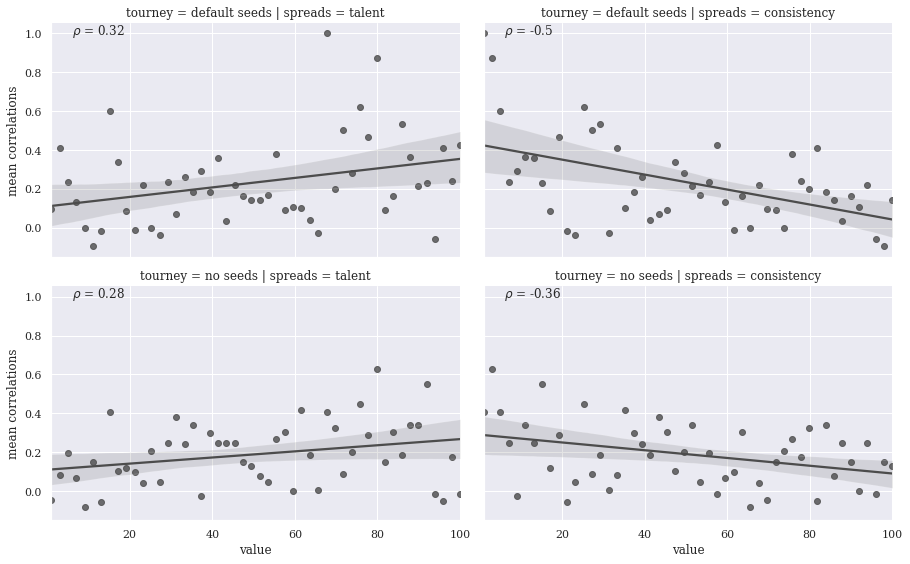

In [23]:
size = 8
a = tstruct(size)

nsim = 10
spreads = 50
mu_range = (1, 100)
sigma_range = (1, 100)

# list items: arguments to tourney: heat_size, top, top_fraction, seed, reseed
t = {'default seeds': [2, 1, 1, True, False],
     'no seeds': [2, 1, 1, False, False]}
#t = {'default seeds': [2, 1, 1, True, False]}

a.plot_player_specs(t, nsim, spreads, mu_range, sigma_range)

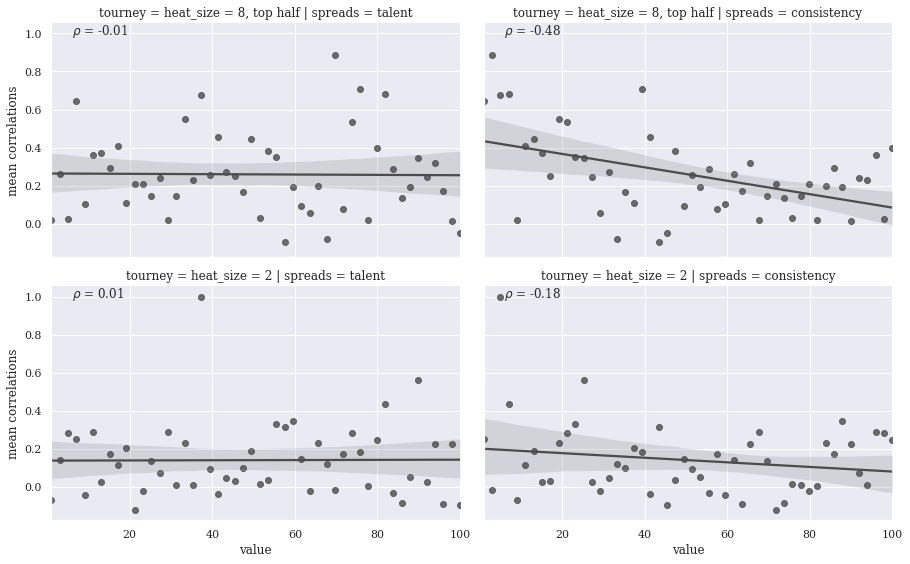

In [26]:
size = 8
a = tstruct(size)

nsim = 10
spreads = 50
mu_range = (1, 100)
sigma_range = (1, 100)

# list items: arguments to tourney: heat_size, top, top_fraction, seed, reseed
t = {'heat_size = 8, top half': [8, 1, 0.5, False, False],
     'heat_size = 2': [2, 1, 1, False, False]}
#t = {'default seeds': [2, 1, 1, True, False]}

a.plot_player_specs(t, nsim, spreads, mu_range, sigma_range)

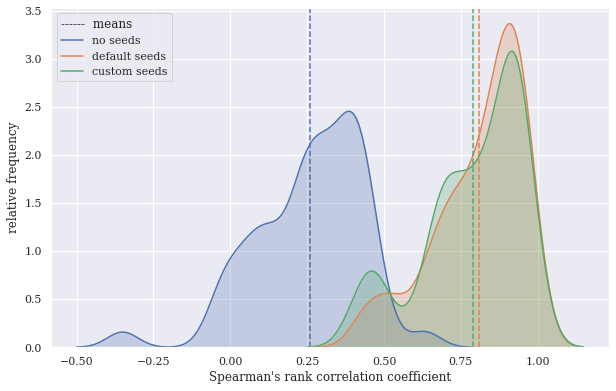

In [27]:
size = 9
spread = 30
nsim = 50

B = -2
R = -1
sd = [[1,B,B,B],
      [2,R,R,R],
      [3,4,R,R]]

a = tstruct(size)
a.players.iloc[0] = np.linspace(0, spread, size, dtype=float)
a.players.iloc[1] = a.players.iloc[0]/2
#a.players.iloc[1] = 5

# list items: arguments to tourney: heat_size, top, top_fraction, seed, reseed
t = {'no seeds': [4, 1, 1, False, False],
     'default seeds': [4, 1, 1, True, False],
     'custom seeds': [4, 1, 1, sd, False]}

a.plot_corrs_distribution(t, nsim)

In [28]:
a.generate_seed_order(9,4).reshape(4,4)+1

array([[ 1,  8, 12, 16],
       [ 2,  7, 11, 15],
       [ 3,  6, 10, 14],
       [ 4,  5,  9, 13]])

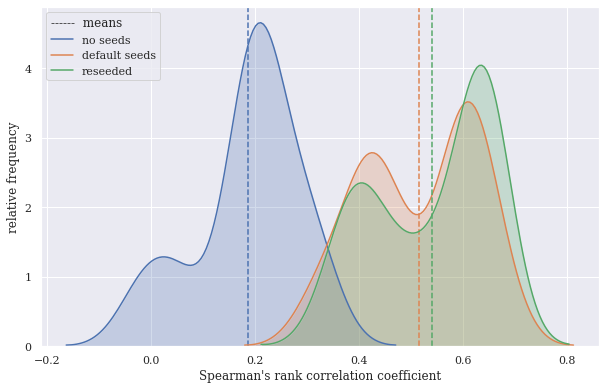

In [29]:
size = 64
spread = (30,30)
nsim = 10

a = tstruct(size)
a.players.iloc[0] = np.linspace(0, spread[0], size, dtype=float)
a.players.iloc[1] = np.linspace(0, spread[1], size, dtype=float)
#a.players.iloc[1] = 5

# list items: arguments to tourney: heat_size, top, top_fraction, seed, reseed
t = {'no seeds': [2, 1, 1, False, False],
     'default seeds': [2, 1, 1, True, False],
     'reseeded': [2, 1, 1, True, True]}

a.plot_corrs_distribution(t, nsim)

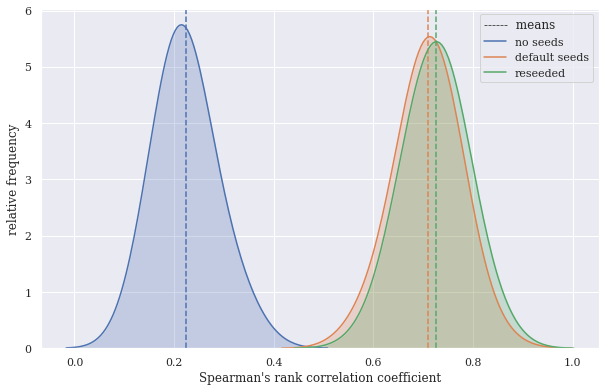

In [30]:
size = 64
spread = (30,10)
nsim = 50

a = tstruct(size)
a.players.iloc[0] = np.linspace(0, spread[0], size, dtype=float)
#a.players.iloc[1] = np.linspace(0, spread[1], size, dtype=float)
a.players.iloc[1] = spread[1]

# list items: arguments to tourney: heat_size, top, top_fraction, seed, reseed
t = {'no seeds': [2, 1, 1, False, False],
     'default seeds': [2, 1, 1, True, False],
     'reseeded': [2, 1, 1, True, True]}

a.plot_corrs_distribution(t, nsim)

## Hot Wheels Times

In [31]:
hw_times = {'Daytona':        [2.56, 2.35, 2.68, 2.67, 2.71, 2.7, 2.92, 2.8, 
                               2.72, 2.79, 2.65, 2.77, 2.75, 3.13, 2.67, 2.75, 
                               2.6, 2.58, 2.6, 2.79, 2.43, 2.42, 2.48, 2.35, 
                               3.09, 2.63, 2.45, 2.59, 2.56, 2.67, 2.54, 2.4, 
                               2.74, 2.43],
             'Tumbler':       [2.38, 2.56, 2.86, 2.89, 2.82, 2.59, 2.66, 2.83, 
                               2.9, 2.65, 2.7, 2.6, 2.56, 2.76, 2.61, 2.47, 
                               2.62, 2.46, 2.72, 2.58, 2.61, 2.7, 2.55, 2.73, 
                               2.33, 2.61, 3.1, 2.71, 2.13, 2.31, 2.62, 2.47, 
                               2.31, 2.57],
             'Driftsta':      [2.69, 2.78, 2.89, 3.42, 2.88, 2.7, 2.83, 3.13, 
                               2.58, 2.43, 2.63, 2.77, 2.64, 2.77, 2.71, 2.85, 
                               2.93, 2.6, 2.65, 2.65, 2.63, 2.72, 2.85, 2.55, 
                               2.61, 2.76, 3.04, 3.1, 2.59, 2.52, 2.63, 2.63, 
                               2.6, 2.25],
             'Iroc-Z':        [2.61, 2.7, 3.09, 2.67, 2.74, 2.76, 2.87, 2.78, 
                               2.61, 2.74, 2.1, 2.61, 2.96, 2.76, 2.79, 2.69, 
                               3.19, 3.02, 2.72, 2.73, 2.5, 2.7, 2.47, 2.84, 
                               2.57, 2.79, 2.77, 2.36, 2.77, 2.8, 2.67, 2.72, 
                               2.54, 2.61],
             'Aventador':     [2.65, 2.36, 2.69, 2.62, 2.59, 2.64, 2.83, 2.63, 
                               2.63, 2.51, 2.7, 2.73, 2.61, 2.49, 2.71, 2.55, 
                               2.53, 2.59, 2.61, 2.96, 2.73, 2.38, 2.64, 2.84, 
                               2.5, 2.49, 2.7, 2.88, 2.37, 2.44, 2.43, 2.4, 
                               2.66, 2.54],
             'Super Blitzen': [2.61, 2.86, 3.12, 2.72, 2.84, 2.92, 2.73, 2.72, 
                               2.89, 2.83, 2.99, 2.9, 2.77, 2.83, 2.75, 2.85, 
                               2.84, 2.59, 2.66, 2.92, 2.51, 2.78, 2.62, 2.8, 
                               2.73, 2.73, 2.91, 2.52, 2.91, 2.74, 2.73, 2.66, 
                               2.5, 2.78],
             'DaKar':         [2.13, 2.87, 2.73, 2.79, 2.72, 2.64, 2.67, 2.74, 
                               2.55, 2.55, 2.57, 2.78, 2.47, 2.59, 2.66, 3.03, 
                               2.57, 2.53, 2.47, 2.78, 2.56, 2.71, 2.86, 2.44, 
                               2.57, 2.73, 2.75, 2.63, 2.4, 2.82, 2.49, 2.53, 
                               2.24, 2.65],
             'Spector':       [2.31, 2.47, 2.66, 2.74, 2.64, 2.65, 2.7, 2.81, 
                               2.43, 2.47, 2.29, 2.51, 2.53, 2.49, 2.68, 2.55, 
                               2.41, 2.42, 2.38, 2.46, 2.47, 2.35, 2.33, 2.34, 
                               2.29, 2.47, 2.82, 2.43, 2.54, 2.43, 2.42, 2.45, 
                               2.43, 2.73]} 

df = pd.DataFrame(hw_times)
df.describe()

,Daytona,Tumbler,Driftsta,Iroc-Z,Aventador,Super Blitzen,DaKar,Spector
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,2.646176,2.616765,2.735588,2.713235,2.606765,2.772353,2.624118,2.502941
std,0.183980,0.194667,0.216909,0.198826,0.146633,0.139176,0.178548,0.147495
min,2.350000,2.130000,2.250000,2.100000,2.360000,2.500000,2.130000,2.290000
25%,2.545000,2.552500,2.615000,2.610000,2.502500,2.720000,2.535000,2.420000
50%,2.660000,2.610000,2.695000,2.725000,2.615000,2.775000,2.635000,2.470000
75%,2.747500,2.717500,2.845000,2.787500,2.697500,2.857500,2.737500,2.617500
max,3.130000,3.100000,3.420000,3.190000,2.960000,3.120000,3.030000,2.820000


In [32]:
slide_race = tstruct(8)
slide_race.players.columns = df.columns
slide_race.players.loc['mu'] = list(df.mean(axis=0))
slide_race.players.loc['sigma'] = list(df.std(axis=0))

slide_race.new_scores()

resulto = slide_race.tourney(heat_size=2, top=1, top_fraction=1, 
                             seed=True, reseed=False, 
                             show_brackets=True, show_stats=True)

resulto

Final Rank  1                                                           DaKar
            2                                                       Aventador
            3                                                   Super Blitzen
            4                                                          Iroc-Z
            5                                                        Driftsta
            6                                                         Daytona
            7                                                         Tumbler
            8                                                         Spector
Statistics  nscores_used                                                   14
            nscores                                                        24
            efficiency                                               0.583333
            rho_avg                                                  0.214286
            rho_mu                                              

In [33]:
resulto['Brackets'][0]

[['Spector', 'Super Blitzen'],
 ['DaKar', 'Daytona'],
 ['Aventador', 'Driftsta'],
 ['Tumbler', 'Iroc-Z']]

In [34]:
slide_race.players

,Daytona,Tumbler,Driftsta,Iroc-Z,Aventador,Super Blitzen,DaKar,Spector
mu,2.646176,2.616765,2.735588,2.713235,2.606765,2.772353,2.624118,2.502941
sigma,0.183980,0.194667,0.216909,0.198826,0.146633,0.139176,0.178548,0.147495


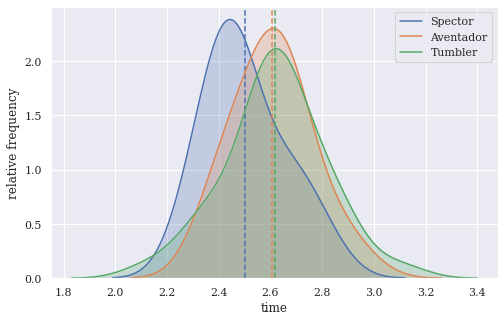

In [35]:
#for car in df.columns:
for car in ['Spector','Aventador','Tumbler']:
    ax = sns.distplot(df[car], hist=False, label = car,
                      norm_hist=True, kde_kws={"bw":0.1, 'shade':True})
    c = ax.get_lines()[-1].get_c()    
    plt.axvline(df[car].mean(), color=c, linestyle='--')
    legend_title = "------  means"   
ax.set(xlabel='time', ylabel='relative frequency')

plt.legend()
plt.show()

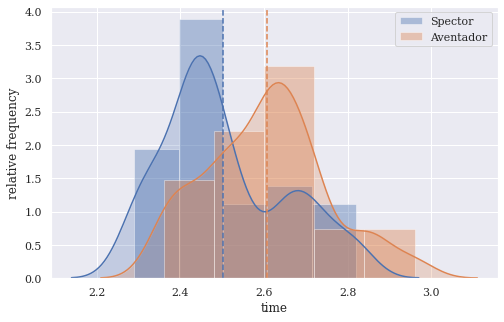

In [36]:
#for car in df.columns:
for car in ['Spector','Aventador']:
    ax = sns.distplot(df[car], hist=True, label = car,
                      norm_hist=True, kde_kws={"bw":0.05, 'shade':True})
    c = ax.get_lines()[-1].get_c()    
    plt.axvline(df[car].mean(), color=c, linestyle='--')
    legend_title = "------  means"   
ax.set(xlabel='time', ylabel='relative frequency')


plt.legend()
plt.show()